- Introduction and About Yelp  (talk about the dataset and pertinent class labels)
- What is Sentiment Analysis in the Context of AI and NLP?  e.g. text classification  
- Framing the Problem Statement  
> What is the main objective and what are we trying to achive?  It might be best to **not** to only state predict whether review is positive, negative, or neutral but something more insightful/meaningful.  Keep in mind that sentiment analysis is nothing new and there are a number of implementations.       
- Data Analysis, Cleaning, and Transformation    
- Exploration and Visualization e.g. provide a bit of insight into the dataset.        
- Addressing Data imbalance (or class weights)    
- NLP: Word Tokenization, Sequences, and Embedding  
- RNN/LSTM(Bidirectional)/GRU  
> Overview of the RNN architecture.  Why a type of RNN, LSTM, applies to sentiment analysis.  Describe the archicture.  
- Transfer Learning  
> Can we have done Transfer Learning with pre-built models?  Does augmenting with Transfer Learning make any difference?
- SaS  
- Optimization Techniques  
- Addressing Over-Fitting  
- Predictions and Generating Text e.g. Auto-Completion  
> Does a model perform just as well on other context or domains?
- Evaluating Performance (Confusion Matrix)   
- Productionizing the Trained Model via API in AWS    
- Conclusion
> Provide the intuition behind the result. Why the model performed the way it did and what accounted for the performance.

<img src="cnn.png" alt="cnn key points" />

In [1]:
import datetime
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

# 3rd-part library for managing imbalanced data.
from imblearn.under_sampling import RandomUnderSampler
from IPython.core.interactiveshell import InteractiveShell

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:

%matplotlib inline

# Set dataframe options to keep long data in columns from being truncated with ellipsis (...)
pd.set_option('max_colwidth', None)

# Set dataframe options to force display max columns
pd.set_option('display.max_columns', 90)
pd.set_option('display.max_rows', 90)

InteractiveShell.ast_node_interactivity = "all"

random_state = 42


# Check if using a GPU
print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.config.list_physical_devices('GPU') else '\t\u2022 GPU device not found. Running on CPU')


Using:
	• TensorFlow version: 2.1.0
	• tf.keras version: 2.2.4-tf
	• Running on GPU


In [61]:

def create_dataframe(file_path):
    '''
    Create a pandas dataframe from a JSON file indicated by the parameter file_path
    '''
    data = []
    with open(file_path, encoding="utf8") as f:
        for jsonObj in f:
            data.append(json.loads(jsonObj))
    return pd.DataFrame(data)


def df_info(df):
    '''
    A helper function - similar in functionality with `df.info()` but includes combined features: df.columns, df.dtypes, 
    df.isnull(), df.info(), df.nunique()
    '''
    print('\nShape : {}'.format(df.shape))
    print('Number of duplicates : {}\n'.format(df.duplicated().sum()))

    print('{:^35} {:^12} {:^12} {:^8} {:>10}\n'.format('COLUMNS', 'DATA TYPE', 'HAS NULL', 'COUNTS', '# UNIQUE'))
    for i, v in enumerate(df.columns):
        col = df[v]
        dtype = type(col.iloc[0]).__name__
        
        if dtype=='dict':
            keys = set([item for val in col.values if val is not None for item in list(val.keys())])
            col_nunique = len(keys)
        else:
            col_nunique = col.nunique()
        
        print(' {:>2}.  {:<30} {:<12} {:^10} {:>8} {:>10}'.format(i+1, v, dtype, \
                                                                  str(col.isnull().any()), col.count(), \
                                                                  col_nunique))    # col.nunique()

        
def plot(history_data):
    '''
    Plot history data
    '''
    training_accuracy = history_data.history['accuracy']
    validation_accuracy = history_data.history['val_accuracy']

    training_loss = history_data.history['loss']
    validation_loss = history_data.history['val_loss']

    epochs_range=range(len(training_accuracy))

    fig = plt.figure(figsize=(10, 3.5), constrained_layout=True)
    gs = fig.add_gridspec(1, 6)
    fig_ax1 = fig.add_subplot(gs[0,:-3])
    fig_ax2 = fig.add_subplot(gs[0,3:])
    
    fig_ax1.plot(epochs_range, training_accuracy, label='Training Accuracy')
    fig_ax1.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
    fig_ax1.legend(loc='lower right')
    fig_ax1.set_title('Training and Validation Accuracy')

    fig_ax2.plot(epochs_range, training_loss, label='Training Loss')
    fig_ax2.plot(epochs_range, validation_loss, label='Validation Loss')
    fig_ax2.legend(loc='upper right')
    fig_ax2.set_title('Training and Validation Loss')


Load the JSON dataset and persist as a CSV file.
> **Warning:** This process will take some to complete.

In [4]:

review_json = '../yelp_dataset/yelp_academic_dataset_review.json'
reviews_df = create_dataframe(review_json)
df_info(reviews_df)



Shape : (8021122, 9)
Number of duplicates : 0

              COLUMNS                DATA TYPE     HAS NULL    COUNTS    # UNIQUE

  1.  review_id                      str            False     8021122    8021122
  2.  user_id                        str            False     8021122    1968703
  3.  business_id                    str            False     8021122     209393
  4.  stars                          float64        False     8021122          5
  5.  useful                         int64          False     8021122        266
  6.  funny                          int64          False     8021122        209
  7.  cool                           int64          False     8021122        200
  8.  text                           str            False     8021122    7999488
  9.  date                           str            False     8021122    7853102


Filter the dataframe to the features that are only needed.

In [5]:
reviews_dataset = reviews_df.drop(['review_id', 'user_id', 'useful', 'funny', 'cool', 'date'], axis=1)

***
Reviews are from different type of establishments. Check to see if this can be filtered down to only dine/drink type of establishments where our sentiment analysis will focus on.

In [6]:
business_json = '../yelp_dataset/yelp_academic_dataset_business.json'
business_df = create_dataframe(business_json)
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209393 entries, 0 to 209392
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   209393 non-null  object 
 1   name          209393 non-null  object 
 2   address       209393 non-null  object 
 3   city          209393 non-null  object 
 4   state         209393 non-null  object 
 5   postal_code   209393 non-null  object 
 6   latitude      209393 non-null  float64
 7   longitude     209393 non-null  float64
 8   stars         209393 non-null  float64
 9   review_count  209393 non-null  int64  
 10  is_open       209393 non-null  int64  
 11  attributes    180348 non-null  object 
 12  categories    208869 non-null  object 
 13  hours         164550 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 22.4+ MB


The `categories` feature will be used to filter businesses to dine/drink.

In [7]:
# Business criteria: Restaurants, Bars, Pub, or wherever there's Food
eat_drink_business_df = business_df.query('not categories.isnull() and \
                  (categories.str.contains("Food") or categories.str.contains("Restaurants") \
                   or categories.str.contains("Bars") or categories.str.contains("Pub"))', 
                  engine='python')

eat_drink_business_df[['name', 'categories']].sample(5)

,name,categories
124386,La Tortilleria,"Mexican, Restaurants"
175538,Wendy's,"Fast Food, Restaurants, Burgers"
26617,America Latina,"Breakfast & Brunch, Mexican, Restaurants, American (Traditional)"
46709,FruiteaO,"Restaurants, Food, Desserts, Taiwanese, Tea Rooms, Juice Bars & Smoothies"
85194,Enso Tea Bar,"Acai Bowls, Food, Bubble Tea, Juice Bars & Smoothies"


Now that the dataset is filtered down to the type of establishments we need, the `is_open` feature can be used to only capture establishments that are still in business.

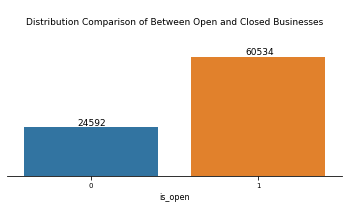

In [8]:
results = eat_drink_business_df.is_open
params = {'axes.spines.top':False, 'axes.spines.right': False, 'axes.spines.left': False, 'axes.labelsize' : 8, 
          'xtick.labelsize' : 7, 'axes.titlesize':9}
matplotlib.rcParams.update(params)
fig = plt.figure(constrained_layout=False, figsize=(6, 2.3))
ax = fig.gca()
ax.set_title('\nDistribution Comparison of Between Open and Closed Businesses\n\n')
p = sns.countplot(x=results, ax=ax)
ax.yaxis.set_visible(False)
counts=pd.Series(results).value_counts().sort_values(ascending=True)
for i, count in enumerate(counts):
    ax.text(i-.08, count+1000, '{}'.format(count), fontsize=9)

matplotlib.rcParams.update(matplotlib.rcParamsDefault);

> `24.5`k have gone out of business.

In [9]:
establishments_still_in_business = eat_drink_business_df.query('is_open == 1').business_id

reviews_dataset_open = reviews_dataset.query('business_id in @establishments_still_in_business')
df_info(reviews_dataset_open)



Shape : (4733942, 3)
Number of duplicates : 9393

              COLUMNS                DATA TYPE     HAS NULL    COUNTS    # UNIQUE

  1.  business_id                    str            False     4733942      60534
  2.  stars                          float64        False     4733942          5
  3.  text                           str            False     4733942    4722100


> Dataset is reduced to 4.7 million and comprises only of establishments that are still in business.

There is no need for `business_id` at this point and can be dropped.

In [10]:
reviews_dataset_2features = reviews_dataset_open.drop(['business_id'], axis=1, inplace=False)

Review the distribution of the `stars` feature.

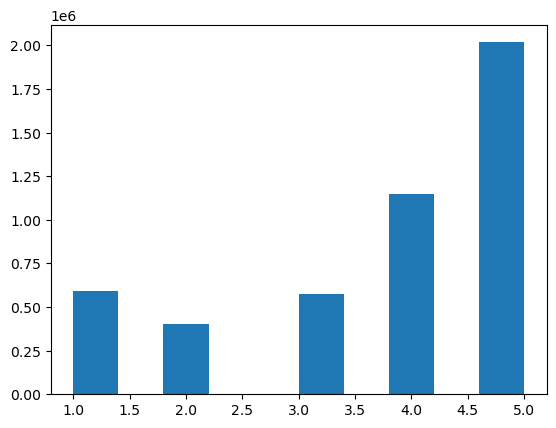

In [11]:
plt.hist(reviews_dataset_2features.stars);

Patrons rate establishments from 1 through 5 with 5 being the highest.  The `stars` value will be able to provide the appropriate label to the sentiments.  
However in lieu of the star ratings, this can be collated into: `negative`, `neutral`, `positive`.  
Reviews with 1 and 2 will fall into the negative, 3 into neutral, 4 and 5 into positive.

In [12]:
category_labels = [0, 1, 2]
cut_bins = [0, 2, 3, 5]
reviews_dataset_2features['sentiment'] = pd.cut(reviews_dataset_2features['stars'], bins=cut_bins, labels=category_labels)

Review the changes in the dataset; should now see the new column `sentiment`.

In [13]:
reviews_dataset_2features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4733942 entries, 2 to 8021121
Data columns (total 3 columns):
 #   Column     Dtype   
---  ------     -----   
 0   stars      float64 
 1   text       object  
 2   sentiment  category
dtypes: category(1), float64(1), object(1)
memory usage: 112.9+ MB


**Test the changes**.  All three queries should **not** return any values.

In [14]:
reviews_dataset_2features.query('stars == 3 and (sentiment == 2 or sentiment == 0)')
reviews_dataset_2features.query('stars < 3 and (sentiment == 1 or sentiment == 2)')
reviews_dataset_2features.query('stars > 3 and (sentiment == 0 or sentiment == 1)')

,stars,text,sentiment


,stars,text,sentiment


,stars,text,sentiment


Now that the `sentiment` feature has been created, there is no need for the `stars` feature.

In [15]:
reviews_dataset_2features.drop(['stars'], inplace=True, axis=1)

Persist the stripped-down dataset to make it more manageable and resource-utilization-friendly.

In [16]:
# Save the data to a new CSV file
reviews_dataset_2features.to_csv('../yelp_dataset/reviews_dataset.csv', index=False)

Re-load the dataset as `reviews_sentiments`.

In [17]:
reviews_sentiments = pd.read_csv('../yelp_dataset/reviews_dataset.csv')
df_info(reviews_sentiments)


Shape : (4733942, 2)
Number of duplicates : 11386

              COLUMNS                DATA TYPE     HAS NULL    COUNTS    # UNIQUE

  1.  text                           str             True     4733941    4722099
  2.  sentiment                      int64          False     4733942          3


> Initially the dataset did not have any NA values but after re-loading, it now appears we do.  This is because 'N/A' was interpreted as string during JSON conversion but is now recognized by `pandas` as a `NA` value after reloading the dataset.

Since NA values in text does not provide any meaningful data, it is pointless to keep this hence rows with NA is dropped.

In [18]:
reviews_sentiments.dropna(inplace=True)

Duplicates now appear in the dataset and needs to be investigated.

In [19]:
reviews_sentiments[1000:10000][reviews_sentiments[1000:10000].duplicated(subset=['text'], keep=False)]

,text,sentiment
7505,"Some cravings you just can't ignore! Today was our first time visiting Popcorn Heaven in Ballantyne. The smells alone are worth the trip! We were immediately greeted by the sales clerk who was helping another customer. (Call me old fashioned, but I like to be acknowledged. Her smile made us feel very welcomed!) Then Daniel the owner welcomed us and explained the menu, purchase options & specials. This place has folks pouring in & they all knew what they wanted. While my husband and I were trying to make a decision on flavors, Daniel graciously offered samples. It was...heavenly! Deee-lish! Fresh! Popcorn Heaven also ships! Prices were great when compared to online companies. I love shopping local & Popcorn Heaven will definitely be keeping my business! Oh, one last thought- Daniel said they make nice gift baskets for Valentines day. Seriously friends, give Popcorn Heaven a try!",2
9082,"Some cravings you just can't ignore! Today was our first time visiting Popcorn Heaven in Ballantyne. The smells alone are worth the trip! We were immediately greeted by the sales clerk who was helping another customer. (Call me old fashioned, but I like to be acknowledged. Her smile made us feel very welcomed!) Then Daniel the owner welcomed us and explained the menu, purchase options & specials. This place has folks pouring in & they all knew what they wanted. While my husband and I were trying to make a decision on flavors, Daniel graciously offered samples. It was...heavenly! Deee-lish! Fresh! Popcorn Heaven also ships! Prices were great when compared to online companies. I love shopping local & Popcorn Heaven will definitely be keeping my business! Oh, one last thought- Daniel said they make nice gift baskets for Valentines day. Seriously friends, give Popcorn Heaven a try!",2


> Selecting a subset/range of rows from the dataset, confirms that there are indeed duplicates.  It seems that after converting the JSON object into a dataframe, the `duplicated` function does not seem to work as expected.

Duplicates have no value and is a waste in resource so these need to be dropped.

In [20]:
reviews_sentiments.drop_duplicates(inplace=True)

Persist the dataset and reload.

In [21]:
# persist
reviews_sentiments.to_csv('../yelp_dataset/reviews_dataset.csv', index=False)

In [22]:
# reload
reviews_sentiments = pd.read_csv('../yelp_dataset/reviews_dataset.csv')
df_info(reviews_sentiments)


Shape : (4722555, 2)
Number of duplicates : 0

              COLUMNS                DATA TYPE     HAS NULL    COUNTS    # UNIQUE

  1.  text                           str            False     4722555    4722099
  2.  sentiment                      int64          False     4722555          3


> Dataset looks much cleaner now.

Divide the dataset into features and labels.

In [23]:
X = reviews_sentiments[['text']]
y = reviews_sentiments['sentiment']

The sentiment serves as a label to help in the process of training the model in the classification of reviews.
To effectively train the model with the dataset, we need to ensure the data has a balanced number of classifications.

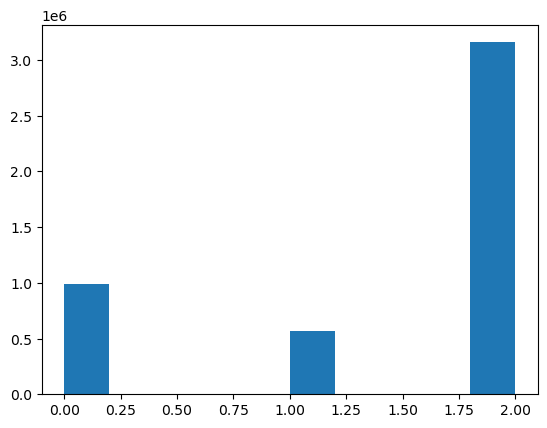

In [24]:
plt.hist(y);

> There is an imbalance in the dataset where there are significantly more `positive` rating than the other two sentiments.

To avoid bias where model is trained more on the positive labels, dataset need to be balanced.  A third-party library, `imb-learn` is used to under sample the dataset and balance out to the smallest denominator.

In [25]:

# RandomUnderSampler is used from the imblearn using the sampling-strategy auto
rus = RandomUnderSampler(sampling_strategy='auto', random_state=random_state)

# The result is a resampled dataset of X and y
X_res, y_res = rus.fit_resample(X, y)


Review the newly-balanced dataset.

In [26]:
X_res.shape[0]/reviews_df.shape[0]

0.21371224624185992

In [27]:
# sanity check, X and y should be equal in number of instances
np.shape(X_res), np.shape(y_res)

((1714212, 1), (1714212,))

> The balanced dataset has been reduced to 21.4% of its original size but with 1.71 million, it is still a substantial amount that can be used to train and test the model.

Review the distribution of the sentiments from the newly-balanced dataset.

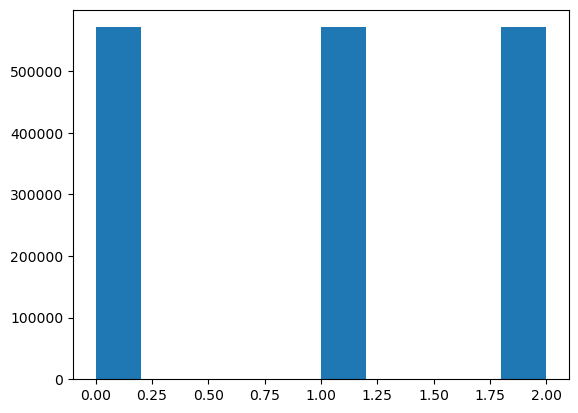

In [28]:
plt.hist(y_res);

> We now have a more balanced dataset across the different sentiments.

**Alternative Option :**  

Assign class weights during the model fit:

`model.fit(..., class_weight={0:1, 1:1, 2 / total nbr rows}`

> Key here is that more weight should be added to the class that has a lesser number of instances.

Split data into train and test.

In [29]:
# Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X_res.values, y_res.values, test_size=0.3)

Get the most number of words in all the reviews from the training dataset.

In [30]:
maxlen = 0
for x in X_train:
    review = x[0]
    if len(review.split()) > maxlen:
        maxlen = len(review.split())

print(maxlen)

1022


> This is the most number of words from one of the reviews.

Get the vocubulary size based on the unique words from the training dataset.

In [31]:
vocubulary = []
ctr=0

for x in X_train:
    unique_words = set(x[0].split())    # for each review, get the unique words
    vocubulary.extend(list(unique_words))    # add to the vocubulary list; duplicate words possible from one review to another

    ctr+=1
    if ctr % 100000 == 0:    
        vocubulary = list(set(vocubulary))    # every nth cycle, ensure uniqueness of the vocubulary

vocubulary = list(set(vocubulary))   # ensure uniqueness one more time
num_words = len(vocubulary)    # this is the size of the vocubulary used by patrons in the reviews dataset
num_words

1322808

How many words should be relevant in a review?  Having a large number of words may potentially add noise and weaken the predicting performance of the model.  Likewise, having a small number of words may not make our model as strong as it is limited to small number of words.  

`num_words` will have to be a hyper-parameter and will determine how many or few to make an effective model. 

In [32]:
tokenizer = Tokenizer(num_words=num_words, oov_token='<oov>')
tokenizer.fit_on_texts(X_train.reshape(X_train.shape[0],).tolist())
word_index = tokenizer.word_index
len(word_index)

279360

In [33]:
sequences = tokenizer.texts_to_sequences(X_train.reshape(X_train.shape[0],).tolist())

Pre-padding(`pre`) or post-padding(`post`)?  What is important for `LSTM`?  
> This can be a hyper-parameter and whichever will make a better performing model will be the selected configuration.

In [34]:
padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding='post')
padded_sequences.shape

(1199948, 1022)

> The `maxlen` parameter in the `pad_sequences` function can be another hyper-parameter.  
> Need to evaluate what makes sense as a length and how it affects the predicting performance of the model.  **Note:** Words will be truncated if the sentence exceeds these number of words.  
> The `truncating` parameter of the `pad_sequences` function should also be considered as a hyper-parameter and whether or not a `pre` or `post` truncating value makes the model stronger.

In [35]:
test_sequences = tokenizer.texts_to_sequences(X_test.reshape(X_test.shape[0],).tolist())
test_padded_sequences = pad_sequences(test_sequences, maxlen=maxlen, padding='post')
test_padded_sequences.shape

(514264, 1022)

Define hyper-parameters for the neural network.

In [36]:
embedding_dimensions = 16
epochs = 10

Build a fully-connected deep-neural network.

In [37]:
tf.keras.backend.clear_session()  

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, embedding_dimensions, input_length=maxlen),
    tf.keras.layers.GlobalAveragePooling1D(),
    #tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.03), 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1022, 16)          21164928  
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 12)                204       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 39        
Total params: 21,165,171
Trainable params: 21,165,171
Non-trainable params: 0
_________________________________________________________________


Train the model, collecting the train and validation metrics.

In [38]:
history = model.fit(padded_sequences, y_train, epochs=epochs, validation_data=(test_padded_sequences, y_test))

Train on 1199948 samples, validate on 514264 samples
Epoch 1/10
1199948/1199948 [==============================] - 6704s 6ms/sample - loss: 0.5578 - accuracy: 0.7606 - val_loss: 0.5366 - val_accuracy: 0.7743
Epoch 2/10
1199948/1199948 [==============================] - 6027s 5ms/sample - loss: 0.5217 - accuracy: 0.7786 - val_loss: 0.5362 - val_accuracy: 0.7731
Epoch 3/10
1199948/1199948 [==============================] - 6042s 5ms/sample - loss: 0.5106 - accuracy: 0.7844 - val_loss: 0.5379 - val_accuracy: 0.7669
Epoch 4/10
1199948/1199948 [==============================] - 6098s 5ms/sample - loss: 0.5032 - accuracy: 0.7880 - val_loss: 0.5636 - val_accuracy: 0.7605
Epoch 5/10
1199948/1199948 [==============================] - 5959s 5ms/sample - loss: 0.4969 - accuracy: 0.7909 - val_loss: 0.5212 - val_accuracy: 0.7815
Epoch 6/10
1199948/1199948 [==============================] - 5893s 5ms/sample - loss: 0.4921 - accuracy: 0.7932 - val_loss: 0.5265 - val_accuracy: 0.7777
Epoch 7/10
119994

> **Note :** This ran for 16.5 hours.
> ### Clearly the parameters are not ideal more so as a starting point.

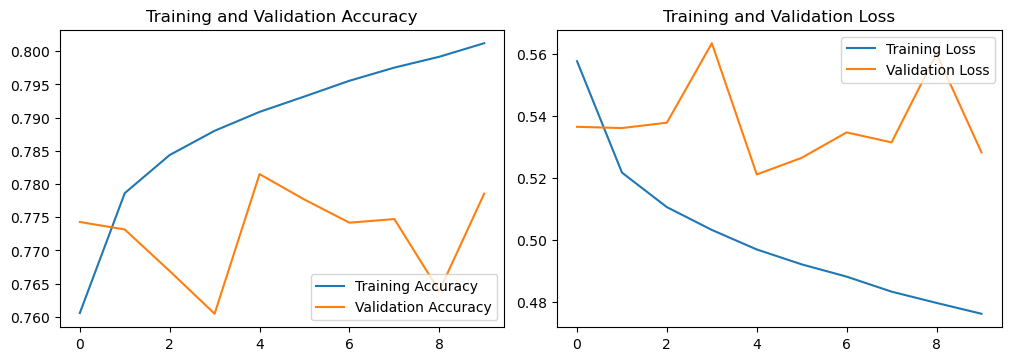

In [62]:
plot(history)

Inputshape=(T, )) where T is the training data padded sequences length (not rows)  
Embedding with LSTM is TxD where T = tokenizer word index + 1 and D = number of dimensions  
LSTM(M, return_sequences=True)  where M is hyper-parameter indicating hidden-state dimensionality  
GlobalMaxPooling1D() because of parameter return_sequences=True  

